# 3D location tracking using Kalman Filter and deep learning

For animations and real world movement tracking (such as GPS navigation), we need to track location (and velocity) of a moving objects. For example, a ball in a 3D space. Noisy location estimates can be simulated. The goals are 3 steps:
1) Using Kalman filter predict movement
2) Use real life images and predict location
3) Use Real life video and object recognition 
4) Use Kalman filter to predict real life object movement
5) Generate a deep learning based kalman filter pipeline


## 1) Using Kalman filter predict movement: intro to Kalman filter
These section has been incorporated from MIT's lecture

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm

In [4]:
# Time step
dt = 0.01 

# total number of measurements
m = 200 

We'll be describing the physical parameters to mimick gravity and drag. A little bit of physics involved to make the movement grounded to reality. This is helful for animations. Position denoted by 'p', velocity by 'v' and acceleration by 'acc'. 3D axes are x, y and z. Keeping the conventions standard

In [5]:
# positions at start
px= 0.0 
py= 0.0
pz= 1.0

# velocities at start
vx = 5.0 
vy = 3.0 
vz = 0.0

# Drag Resistance Coefficient
c = 0.1 

# Damping
d = 0.9 

# Arrays to store location measurements
Xr=[]
Yr=[]
Zr=[]

In [6]:
# # Newton's equation to generate data points
for i in range(0, m):
    
 # update acceleration (deceleration), velocity, position in x direction
    accx = -c*vx**2 
    vx += accx*dt
    px += vx*dt
 # update acceleration (deceleration), velocity, position in y direction
    accy = -c*vy**2
    vy += accy*dt
    py += vy*dt
 # update acceleration, velocity, position in x direction
    accz = -9.806 + c*vz**2 
    vz += accz*dt
    pz += vz*dt
 # if the object is about to hit the base, 
 # change direction, with damping
    if pz<0.01:
        vz=-vz*d
        pz+=0.02
 # add to the arrays storing locations
    Xr.append(px)
    Yr.append(py)
    Zr.append(pz)

In [7]:
# Add random noise to measurements
# Standard Deviation for noise
sp= 0.1 
Xm = Xr + sp * (np.random.randn(m))
Ym = Yr + sp * (np.random.randn(m))
Zm = Zr + sp * (np.random.randn(m))
# stack the measurements together for ease of later use
measurements = np.vstack((Xm,Ym,Zm))

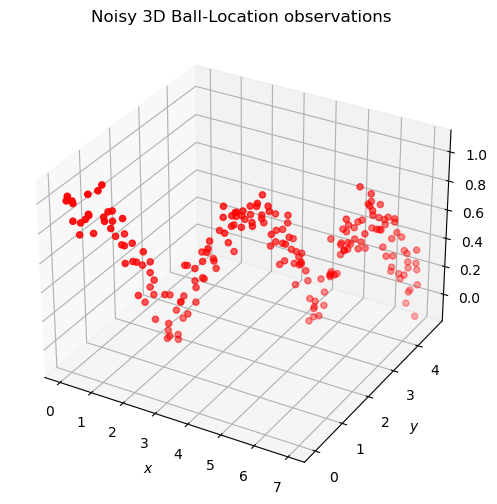

In [8]:
#Plotting random noise with the trajectory
fig = plt.figure(figsize=(10,6))
Three_dplot = fig.add_subplot(111, projection='3d')
Three_dplot.scatter(Xm, Ym, Zm, c='red')
Three_dplot.set_xlabel('$x$')
Three_dplot.set_ylabel('$y$')
Three_dplot.set_zlabel('$z$')
plt.title('Noisy 3D Ball-Location observations')
plt.show()

### Now moving onto a more complex movement.
lower case= prediction, 
UPPER CASE = real values

In [9]:
# Identity matrix
I = np.eye(9)

# state matrix
x = np.matrix([0.0, 0.0, 1.0, 5.0, 3.0, 0.0, 0.0, 0.0, -9.81]).T

# P matrix
P = 100.0*np.eye(9)

In [10]:
I

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [11]:
x

matrix([[ 0.  ],
        [ 0.  ],
        [ 1.  ],
        [ 5.  ],
        [ 3.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [-9.81]])

In [12]:
P

array([[100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 100.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.]])

In [13]:
# A matrix
A = np.matrix([[1.0, 0.0, 0.0, dt, 0.0, 0.0, 1/2.0*dt**2, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0, 1/2.0*dt**2, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0, 1/2.0*dt**2],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

In [14]:
# H matrix
H = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

# R matrix
r = 1.0
R = np.matrix([[r, 0.0, 0.0],
 [0.0, r, 0.0],
 [0.0, 0.0, r]])

# Q, G matrices
s = 8.8
G = np.matrix([[1/2.0*dt**2],
 [1/2.0*dt**2],
 [1/2.0*dt**2],
 [dt],
 [dt],
 [dt],
 [1.0],
 [1.0],
 [1.0]])
Q = G*G.T*s**2

In [15]:
B = np.matrix([[0.0], #Disturbance Control Matrix 
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0]])

In [16]:
u = 0.0 #Control Input

In [17]:
xt = []
yt = []
zt = []
dxt= []
dyt= []
dzt= []
ddxt=[]
ddyt=[]
ddzt=[]
Zx = []
Zy = []
Zz = []
Px = []
Py = []
Pz = []
Pdx= []
Pdy= []
Pdz= []
Pddx=[]
Pddy=[]
Pddz=[]
Kx = []
Ky = []
Kz = []
Kdx= []
Kdy= []
Kdz= []
Kddx=[]
Kddy=[]
Kddz=[]

In [18]:
onFloor = False
for i in range(0, m):
# Model the direction switch, when hitting the plate
    if x[2]<0.02 and not onFloor:
        x[5] = -x[5]
        onFloor=True
# Prediction
# state prediction
    x = A*x + B*u 
# Project the error covariance ahead
    P = A*P*A.T + Q 
# Update
# Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)
# Update the estimate via z
    Z = measurements[:,i].reshape(H.shape[0],1)
    y = Z - (H*x) 
    x = x + (K*y)
# error covariance
    P = (I - (K*H))*P
    
    # Storing results
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    zt.append(float(x[2]))
    dxt.append(float(x[3]))
    dyt.append(float(x[4]))
    dzt.append(float(x[5]))
    ddxt.append(float(x[6]))
    ddyt.append(float(x[7]))
    ddzt.append(float(x[8]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Zz.append(float(Z[2]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pz.append(float(P[2,2]))
    Pdx.append(float(P[3,3]))
    Pdy.append(float(P[4,4]))
    Pdz.append(float(P[5,5]))
    Pddx.append(float(P[6,6]))
    Pddy.append(float(P[7,7]))
    Pddz.append(float(P[8,8]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kz.append(float(K[2,0]))
    Kdx.append(float(K[3,0]))
    Kdy.append(float(K[4,0]))
    Kdz.append(float(K[5,0]))
    Kddx.append(float(K[6,0]))
    Kddy.append(float(K[7,0]))
    Kddz.append(float(K[8,0]))

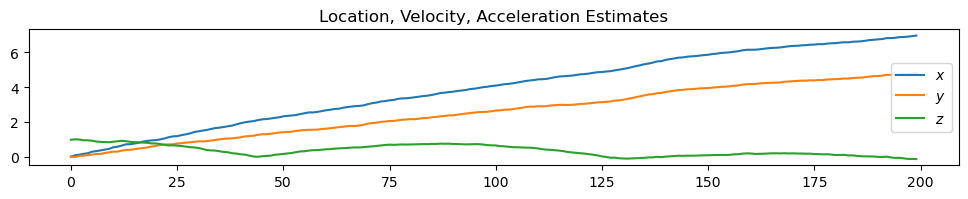

In [19]:
# Plots
#State Estimates
plt.figure(figsize=(12,6))
plt.subplot(311)
plt.title('Location, Velocity, Acceleration Estimates')
plt.plot(range(len(measurements[0])),xt, label='$x$')
plt.plot(range(len(measurements[0])),yt, label='$y$')
plt.plot(range(len(measurements[0])),zt, label='$z$')
plt.legend(loc='right' )

Text(0.5, 0, 'Step')

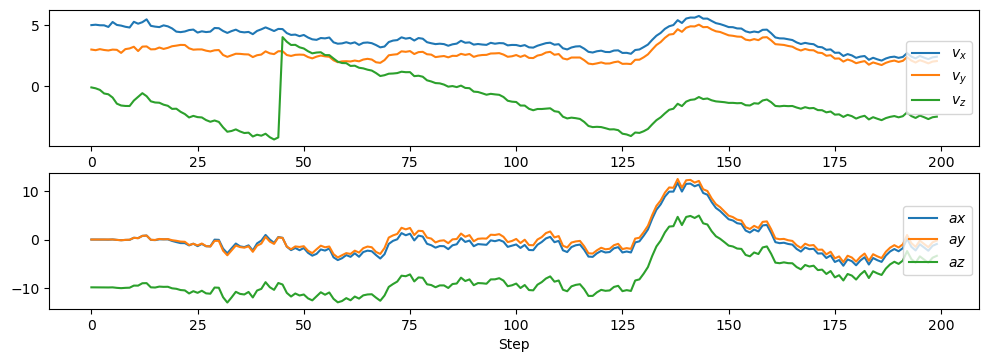

In [20]:
plt.figure(figsize=(12,6))

plt.subplot(312)
plt.plot(range(len(measurements[0])),dxt, label='$v_x$')
plt.plot(range(len(measurements[0])),dyt, label='$v_y$')
plt.plot(range(len(measurements[0])),dzt, label='$v_z$')
plt.legend(loc='right')
plt.subplot(313)
plt.plot(range(len(measurements[0])),ddxt, label='$ax$')
plt.plot(range(len(measurements[0])),ddyt, label='$ay$')
plt.plot(range(len(measurements[0])),ddzt, label='$az$')
plt.legend(loc='right')
plt.xlabel('Step')

Text(0, 0.5, '$y$')

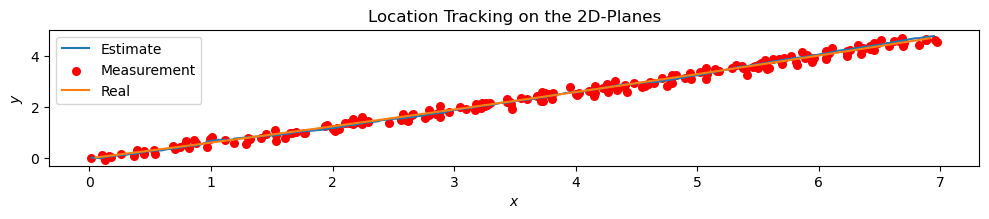

In [21]:
# Location in 2D (z, y)
plt.figure(figsize=(12,6))
plt.subplot(311)
plt.plot(xt,yt, label='Estimate')
plt.scatter(Xm,Ym, label='Measurement', c='red', s=30)
plt.plot(Xr, Yr, label='Real')
plt.title('Location Tracking on the 2D-Planes')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')

Text(0, 0.5, '$z$')

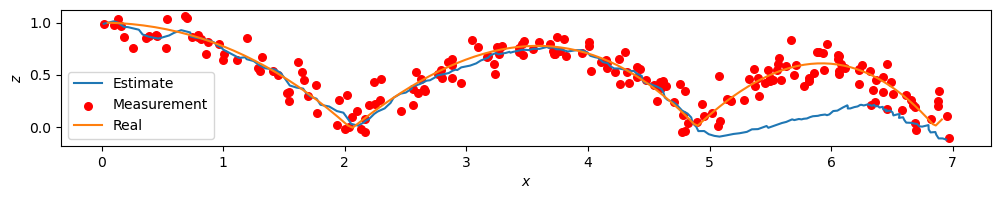

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(312)
plt.plot(xt,zt, label='Estimate')
plt.scatter(Xm,Zm, label='Measurement', c='red', s=30)
plt.plot(Xr, Zr, label='Real')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$z$')


Text(0, 0.5, '$z$')

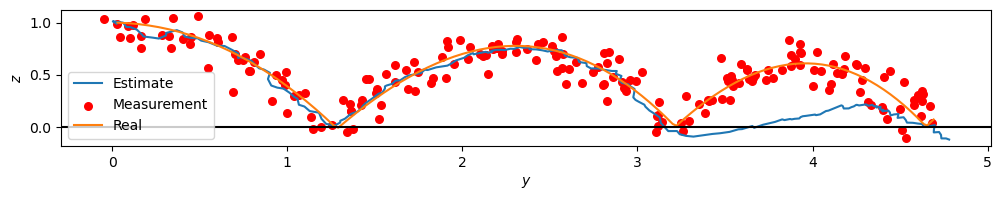

In [23]:
plt.figure(figsize=(12,6))
plt.subplot(313)
plt.plot(yt,zt, label='Estimate')
plt.scatter(Ym,Zm, label='Measurement', c='red', s=30)
plt.plot(Yr, Zr, label='Real')
plt.legend(loc='best')
plt.axhline(0, color='k')
plt.xlabel('$y$')
plt.ylabel('$z$')

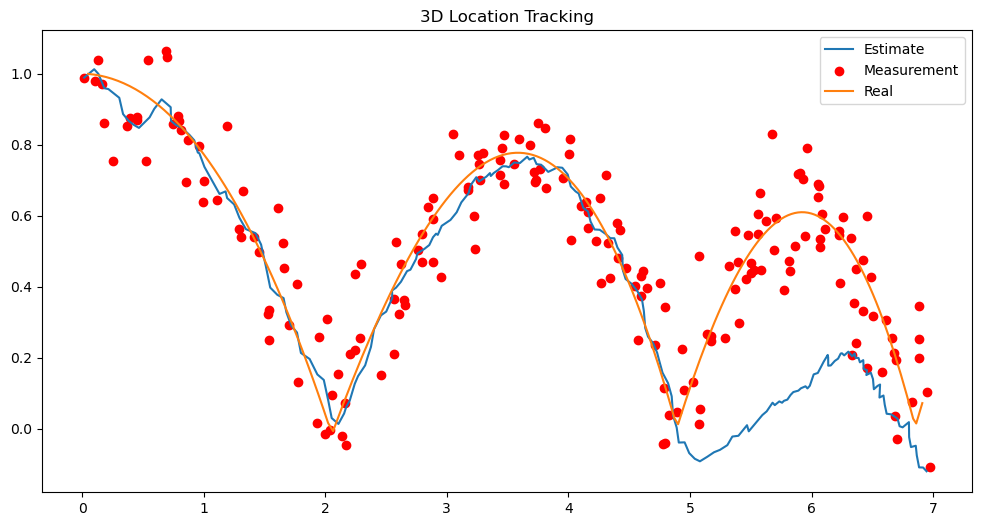

In [24]:
# Position in x/z Plane   
plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
plt.plot(xt,zt, label='Estimate')
plt.scatter(Xm,Zm, label='Measurement', c='red')
plt.plot(Xr,Zr, label='Real')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend()
plt.title('3D Location Tracking')
plt.show()

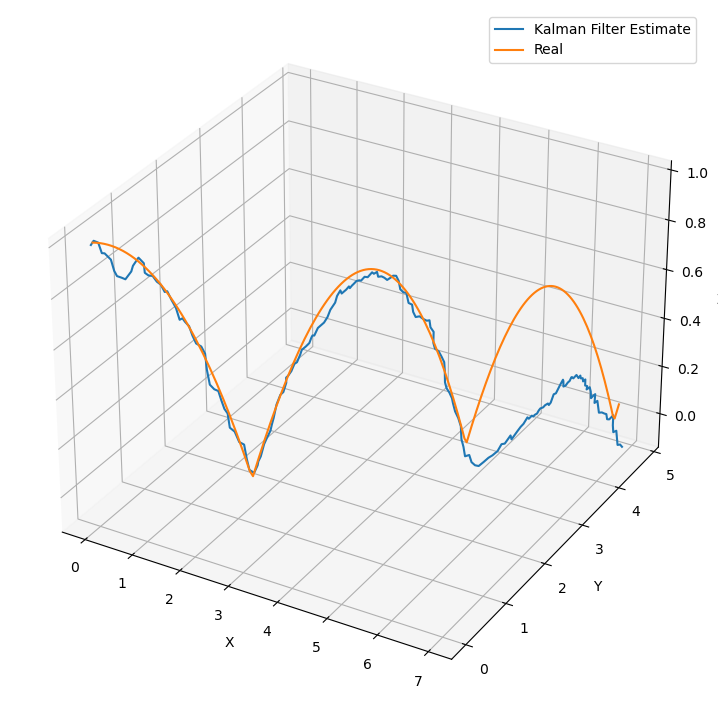

In [25]:
# Location in 3D (X, Y, Z)  
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xt,yt,zt, label='Kalman Filter Estimate')
ax.plot(Xr, Yr, Zr, label='Real')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

## 2) Use real life images and detect object (using opencv and YOLO)

In [28]:
pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/fb/c4/f574ba6f04e6d7bf8c38d23e7a52389566dd7631fee0bcdd79ea07ef2dbf/opencv_python-4.8.0.76-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.2/38.1 MB 7.0 MB/s eta 0:00:06
    --------------------------------------- 0.9/38.1 MB 9.7 MB/s eta 0:00:04
   - -------------------------------------- 1.5/38.1 MB 10.7 MB/s eta 0:00:04
   -- ------------------------------------- 2.3/38.1 MB 12.2 MB/s eta 0:00:03
   --- ------------------------------------ 3.0/38.1 MB 12.5 MB/s eta 0:00:03
   --- ------------------------------------ 3.5/38.1 MB 13.1 MB/s eta 0:00:03
   --- ------------------------------------ 3.6/38.1 MB 11.4 MB/s eta 0:00:04
   ---- ----------------------------------- 3.9/38.1 MB 10.3 MB/s eta 0:00:04
   ---- ----------------------------------- 4.6/38.1 MB 10.8 MB/s eta 0:00:04
   ----- 

In [26]:
import cv2

# Create a Kalman filter
kalman = cv2.KalmanFilter(2, 1)

# Initialize matrices and parameters
kalman.transitionMatrix = np.array([[1, 1], [0, 1]], dtype=np.float32)
kalman.measurementMatrix = np.array([[1, 0]], dtype=np.float32)
kalman.processNoiseCov = 1e-4 * np.eye(2, dtype=np.float32)
kalman.measurementNoiseCov = 1e-1 * np.ones((1, 1), dtype=np.float32)
kalman.errorCovPost = np.ones((2, 2), dtype=np.float32)

# Generate some noisy measurements
measurements = np.array([i + np.random.normal(0, 0.1) for i in range(100)], dtype=np.float32)

# Kalman filter loop
for measurement in measurements:
    prediction = kalman.predict()
    kalman.correct(np.array([[measurement]], dtype=np.float32))

    # Print estimated state
    print("Estimated State:", prediction[0, 0])


Estimated State: 0.0
Estimated State: 0.21783376
Estimated State: 0.90459394
Estimated State: 1.9809291
Estimated State: 3.044865
Estimated State: 4.0518866
Estimated State: 5.041277
Estimated State: 6.0129375
Estimated State: 7.0506797
Estimated State: 8.064565
Estimated State: 9.063226
Estimated State: 10.102509
Estimated State: 11.155579
Estimated State: 12.17786
Estimated State: 13.248194
Estimated State: 14.336166
Estimated State: 15.403674
Estimated State: 16.462095
Estimated State: 17.522507
Estimated State: 18.533003
Estimated State: 19.624462
Estimated State: 20.72604
Estimated State: 21.721622
Estimated State: 22.801239
Estimated State: 23.829815
Estimated State: 24.901695
Estimated State: 25.935303
Estimated State: 26.930445
Estimated State: 27.963776
Estimated State: 28.99843
Estimated State: 30.00494
Estimated State: 30.975609
Estimated State: 32.032642
Estimated State: 33.01142
Estimated State: 34.00321
Estimated State: 35.02582
Estimated State: 36.0424
Estimated State: 3

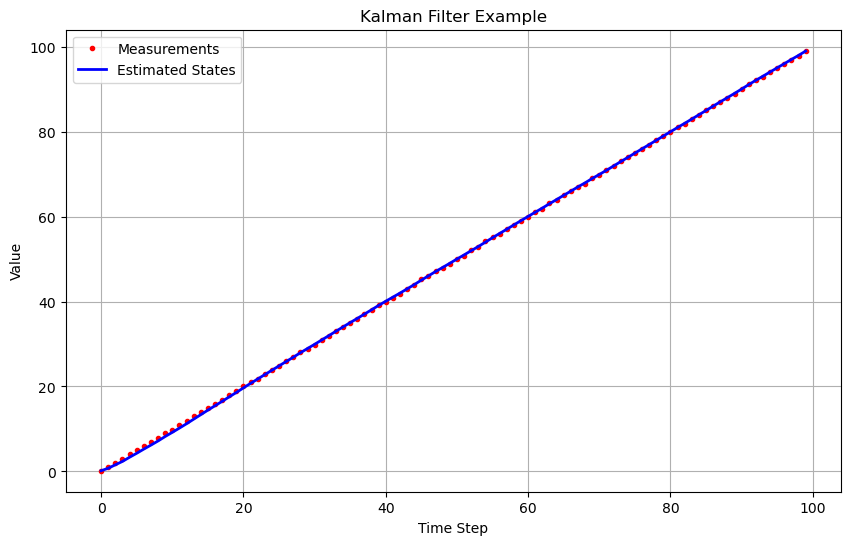

In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Create a Kalman filter
kalman = cv2.KalmanFilter(2, 1)

# Initialize matrices and parameters
kalman.transitionMatrix = np.array([[1, 1], [0, 1]], dtype=np.float32)
kalman.measurementMatrix = np.array([[1, 0]], dtype=np.float32)
kalman.processNoiseCov = 1e-4 * np.eye(2, dtype=np.float32)
kalman.measurementNoiseCov = 1e-1 * np.ones((1, 1), dtype=np.float32)
kalman.errorCovPost = np.ones((2, 2), dtype=np.float32)

# Generate some noisy measurements
measurements = np.array([i + np.random.normal(0, 0.1) for i in range(100)], dtype=np.float32)

# Lists to store estimated states and measurements for plotting
estimated_states = []
all_measurements = []

# Kalman filter loop
for measurement in measurements:
    prediction = kalman.predict()
    estimated_state = kalman.correct(np.array([[measurement]], dtype=np.float32))[0, 0]

    estimated_states.append(estimated_state)
    all_measurements.append(measurement)

# Plot the estimated states and measurements
plt.figure(figsize=(10, 6))
plt.plot(all_measurements, 'ro', markersize=3, label='Measurements')
plt.plot(estimated_states, 'b-', linewidth=2, label='Estimated States')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Kalman Filter Example')
plt.legend()
plt.grid(True)
plt.show()


IndexError: index 1 is out of bounds for axis 1 with size 1

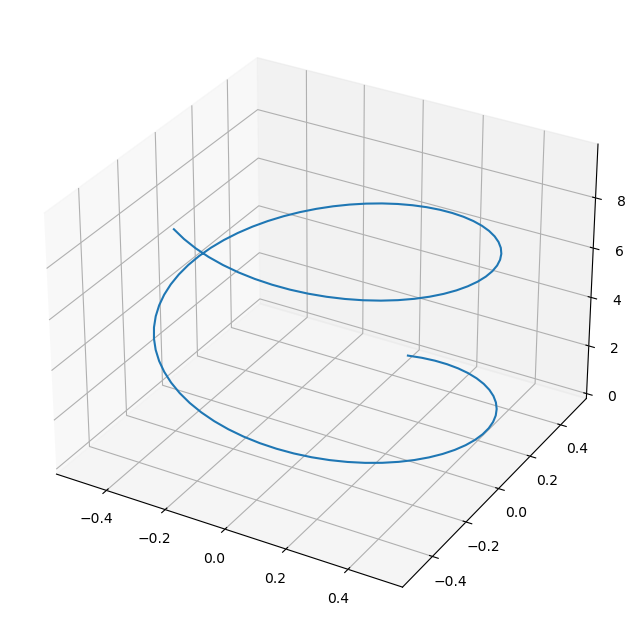

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a Kalman filter for a 6D state (3D position and velocity)
kalman = cv2.KalmanFilter(6, 3)

# Initialize matrices and parameters for 6D state
kalman.transitionMatrix = np.array([
    [1, 0, 0, 1, 0, 0],
    [0, 1, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 1],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1]
], dtype=np.float32)
kalman.measurementMatrix = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0]
], dtype=np.float32)
kalman.processNoiseCov = 1e-4 * np.eye(6, dtype=np.float32)
kalman.measurementNoiseCov = 1e-1 * np.eye(3, dtype=np.float32)
kalman.errorCovPost = np.eye(6, dtype=np.float32)

# Simulate noisy measurements of a bouncing ball
np.random.seed(0)
time_steps = 100
true_states = np.zeros((time_steps, 6))
measurements = np.zeros((time_steps, 3))
for i in range(time_steps):
    true_states[i] = [0.5 * np.sin(0.1 * i), 0.5 * np.cos(0.1 * i), 0.1 * i, 0.05 * np.cos(0.1 * i), -0.05 * np.sin(0.1 * i), 0.1]
    measurements[i] = true_states[i, :3] + np.random.normal(0, 0.1, 3)

# Lists to store estimated states for plotting
estimated_states = []

# Kalman filter loop
for measurement in measurements:
    prediction = kalman.predict()
    measurement = np.array([measurement], dtype=np.float32).reshape(-1, 1)  # Reshape to a column vector
    estimated_state = kalman.correct(measurement)[0]

    estimated_states.append(estimated_state)

# Plot the estimated states and true states in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(true_states[:, 0], true_states[:, 1], true_states[:, 2], label='True States')
estimated_states = np.array(estimated_states)  # Convert list to array
ax.plot(estimated_states[:, 0], estimated_states[:, 1], estimated_states[:, 2],
        label='Estimated States', linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Kalman Filter for 3D Bouncing Ball')
ax.legend()
plt.show()

### Use real life images and predict location: Trying a basic kalman filter method in parallel with object detection using YOLO

In [40]:
kf = cv2.KalmanFilter()
img = cv2.imread(r'C:\Users\aubhi\OneDrive - University of California, San Francisco\Desktop\Springboard\Capstone_like\Kalman Filter\Data\car_2.png')

In [41]:
if img is not None:
    print("Image shape:", img.shape)  # Print the shape of the image
    cv2.imshow('Car Image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Image not loaded properly.")

Image shape: (489, 136, 3)


In [42]:
cv2.imshow('Car Image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Things to be done:

The composite image that contains all the frames stacked vertically.

Determine Frame Heights: Since the frames are stacked vertically, we need to determine the height of each individual frame within the composite image.

Loop Through Frames: Loop through each frame's height and determine the region of interest (ROI) for that frame within the composite image.

Detect Car Position and Mark: Within each ROI, we can use car detection or tracking techniques to determine the car's position and then mark it accordingly.

In [44]:
# Define the number of frames and frame height
num_frames = 4
frame_height = img.shape[0] // num_frames

In [53]:
!pip install yolov3

     ---------------------------------------- 0.0/4.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/4.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/4.9 MB 660.6 kB/s eta 0:00:08
      --------------------------------------- 0.1/4.9 MB 544.7 kB/s eta 0:00:09
      --------------------------------------- 0.1/4.9 MB 581.0 kB/s eta 0:00:09
      --------------------------------------- 0.1/4.9 MB 595.3 kB/s eta 0:00:09
     - -------------------------------------- 0.1/4.9 MB 568.9 kB/s eta 0:00:09
     - -------------------------------------- 0.2/4.9 MB 615.9 kB/s eta 0:00:08
     - -------------------------------------- 0.2/4.9 MB 588.9 kB/s eta 0:00:08
     - -------------------------------------- 0.2/4.9 MB 600.7 kB/s eta 0:00:08
     -- ------------------------------------- 0.3/4.9 MB 630.9 kB/s eta 0:00:08
     -- ------------------------------------- 0.3/4.9 MB 633.2 kB/s eta 0:00:08
     -- ------------------------------------- 0.4/4.9 MB 6

ERROR: Cannot install yolov3==1.0, yolov3==1.1.0, yolov3==1.2, yolov3==1.3, yolov3==1.4, yolov3==1.5, yolov3==1.6 and yolov3==1.7 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [60]:
import cv2
import numpy as np

# Load YOLO model
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

# Load COCO class names
with open('coco.names', 'r') as f:
    classes = f.read().strip().split('\n')

# Get image dimensions
height, width = img.shape[:2]

# Create a blob from the image
blob = cv2.dnn.blobFromImage(img, scalefactor=0.00392, size=(416, 416), swapRB=True, crop=False)

# Set the input to the neural network
net.setInput(blob)

# Get the names of the output layers
layer_names = net.getUnconnectedOutLayersNames()

# Get detection results
outs = net.forward(layer_names)

# Process and visualize the detections
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:  # Filter out low-confidence detections
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            # Draw bounding box and label
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            label = f"{classes[class_id]}: {confidence:.2f}"
            cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image with detections
cv2.imshow('Object Detection', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [62]:
for frame_idx in range(num_frames):
    # Determine the ROI for the current frame
    y_start = frame_idx * frame_height
    y_end = (frame_idx + 1) * frame_height
    roi = img[y_start:y_end, :]

    # Assuming you've detected the car's position as (x, y) within the current ROI
    car_position = (x, y)  # Replace with actual car position

    # Offset the car_position by (0, y_start) to make it relative to the ROI
    car_position_roi = (car_position[0], car_position[1] - y_start)

    # Draw a red point at the car's position within the ROI
    cv2.circle(roi, car_position_roi, 5, (0, 0, 255), 2)  # Red circle, 2-pixel thickness

# Display the composite image with marked car positions
cv2.imshow('Image with Car Positions', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## 3) Use Real life video and object recognition

For this we are going to use the folllowing steps:

1) Install and setup dependencies for a virtual environement
2) Collect and label images
3) Train model use a deep learning architecture : Tensorflow
4) Detect object
5) Freeze and convert
6) Performance tuning



Please follow the next notebook....